# Part 1: Working with images, regions and fixations

Welcome to the first part of our GridFix tutorial. In this part, we will get to know the different objects provided by GridFix to facilitate interactive use of the toolbox in fixation analysis by loading some images, creating a grid parcellation and viewing image fixations.

In [16]:
# Import GridFix toolbox and related modules

%matplotlib inline
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

from gridfix import *

## Loading images and feature maps: the ImageSet object
An _ImageSet_ holds a collection of images or feature maps, each addressed by an individual _imageid_ which is used throughout the toolbox to identify images. As a first step, we are going to load some example images using a CSV file containing image filenames and IDs, then print some information about the resulting ImageSet. It is also possible to load images from a folder and specify _imageids_ explicitly - we are going to do that at a later stage. 

In [17]:
TA_images = ImageSet('TA_images/TA_images.tsv', label='TA_images')
print(TA_images)

# Number of images available using len() and image size as (width, height)
print(len(TA_images))
print(TA_images.size)

# The imageids attribute contains a list of all defined imageids in the set
print(TA_images.imageids)

<gridfix.ImageSet "TA_images", 33 images, size=(512, 320)>
33
(512, 320)
['420666', '211186', '173208', '141108', '469671', '429679', '525903', '2759', '103161', '560427', '175593', '185698', '316505', '439224', '253452', '115866', '547493', '443597', '160421', '272738', '346940', '491098', '575915', '135256', '77951', '351609', '555387', '199634', '449190', '547630', '124759', '6949', '235564']


Images or feature maps are stored as numpy arrays. To see a table (actually, a pandas DataFrame) of all images in the set and their corresponding IDs, you can query the _info_ attribute.

In [18]:
TA_images.info

,imageid,filename,width,height,channels,type,mat_var
0,420666,/Users/zhangwenhu/Desktop/gridfix/TA_images/42...,512,320,3,JPEG,
1,211186,/Users/zhangwenhu/Desktop/gridfix/TA_images/21...,512,320,3,JPEG,
2,173208,/Users/zhangwenhu/Desktop/gridfix/TA_images/17...,512,320,3,JPEG,
3,141108,/Users/zhangwenhu/Desktop/gridfix/TA_images/14...,512,320,3,JPEG,
4,469671,/Users/zhangwenhu/Desktop/gridfix/TA_images/46...,512,320,3,JPEG,
5,429679,/Users/zhangwenhu/Desktop/gridfix/TA_images/42...,512,320,3,JPEG,
6,525903,/Users/zhangwenhu/Desktop/gridfix/TA_images/52...,512,320,3,JPEG,
7,2759,/Users/zhangwenhu/Desktop/gridfix/TA_images/27...,512,320,3,JPEG,
8,103161,/Users/zhangwenhu/Desktop/gridfix/TA_images/10...,512,320,3,JPEG,
9,560427,/Users/zhangwenhu/Desktop/gridfix/TA_images/56...,512,320,3,JPEG,


**Image data** (i.e., the raw floating-point matrices) can be retrieved by passing the corresponding _imageid_ to the ImageSet.images method or simply indexing using ['imageid']. Most gridfix objects also support a `plot()` method to render images and feature maps/values as a matplotlib figure. 

Note: in an interactive IPython/Jupyter session, plotted figures will be displayed immediately and no figure object will be returned. Use `plt.savefig()` to save the most recent figure. When using the gridfix module in a script, `plot()` will return a figure object for further processing. 

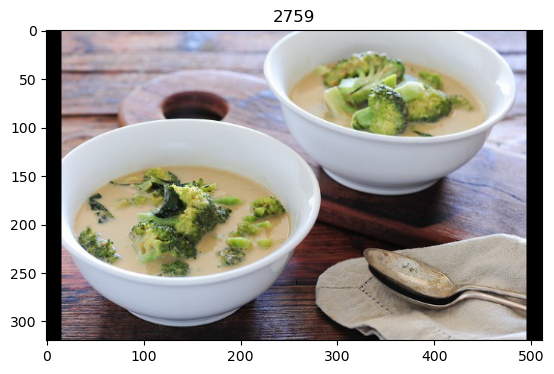

In [34]:
# Raw image data array (uncomment to display)
#print(images['149'])

# Show an image interactively
example_img = '2759'
TA_images.plot(example_img)

# To save the previous figure output to file, use:
#plt.savefig('image10.pdf')

## Defining image parcellations (e.g., regular grid) using a RegionSet
GridFix segments images using a _RegionSet_, which simply holds a collection of binary masks that have the same dimensions as the image(s) they will be applied to. Each mask therefore selects a region from the image. Regions do not have to be contiguous or non-overlapping, and the sum of all regions (available in the `RegionSet.mask` attribute) is not required to cover the whole image area.

In this example, we will use the same regular grid parcellation used in [1]. To define a rectangular grid parcellation such as the 8-by-6 grid used in the above article, we create a GridRegionSet - a special type of RegionSet object which will automatically create the individual masks for each grid cell. Creating a GridRegionSet takes at least two arguments: the size of the corresponding image(s), which we can get from our previously created ImageSet, and the grid dimensions as a (width, height) tuple. 

In [20]:
TA_grid = GridRegionSet(size=TA_images.size, gridsize=(32,20), label='TA_grid')
print(TA_grid)

<gridfix.GridRegionSet (TA_grid), size=(512, 320), 32x20 grid, 640 cells, memory=102400.0 kB>


To quickly visualize a RegionSet (especially when dealing with more complicated parcellations than a simple rectangular grid), each RegionSet object supports the `plot()` method that will create a visual representation in the size of the input images. 

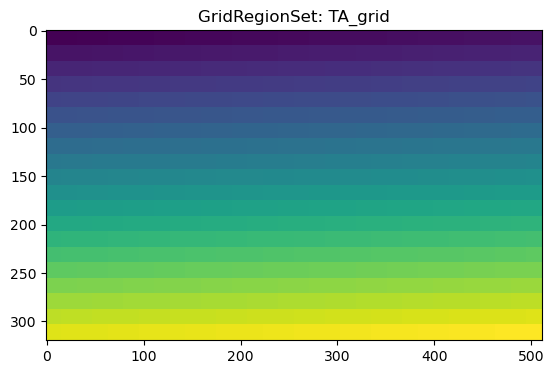

In [21]:
TA_grid.plot()

Even when no fixation data is loaded, a RegionSet can be used to segment an image into subregions, for example to perform image statistics on each region or visualize which parts of an image are selected by a collection of regions of interest. The `apply()` methods returns a list of image arrays, each containing the image patch(es) corresponding to each mask. If you add `crop=True` to the `apply()` call, the resulting output is cropped to the minimal bounding box of each image patch.

Note: For a GridRegionSet, mask numbering starts at the upper left corner and progresses row-wise. 

In [22]:
# Applying the grid to our previously used example image
ex_img = TA_images[example_img] # this yields the image data array
slices = TA_grid.apply(ex_img, crop=True) # slices now contains the selected image data
print(len(slices))

640


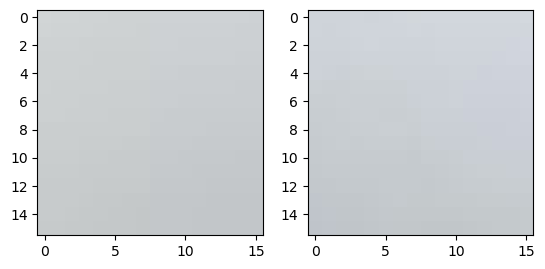

In [23]:
# Display some of the image patches using matplotlib
f = plt.figure()
f1 = f.add_subplot(1,2,1)
plt.imshow(slices[17], interpolation='none')
f2 = f.add_subplot(1,2,2)
plt.imshow(slices[23], interpolation='none')

**Note**: any RegionSet object allows to export the generated image patches as files, either using .export_patches() for a single image array or using .export_patches_from_set() to export all image regions from a complete image set.

In [9]:
# This will export all 48 patches selected from the example image when uncommented
#grid.export_patches(images)

## Loading and viewing image fixations

GridFix stores fixation data in a _Fixations()_ object and expects data in table form, e.g. imported from a CSV text file. Fixation data should be in long format (one fixation per row), and the file must at least include the following columns:

- _imageid_: unique ID for each image (string)
- _fixid_: unique ID for each fixation per trial, e.g. sequential fixation number
- _x_, _y_: horizontal and vertical fixation position in pixels

Column names do not have to be as defined above - if your columns are named differently, the corresponding column names can be submitted when creating the Fixations object (see example below). 

For the tutorial, we will a small fixation data set containing fixations by 8 subjects on our example images:

In [35]:
TA_fix = Fixations('TA_fixations.tsv', imageid='image_id', fixid='CURRENT_FIX_INDEX', 
                x='CURRENT_FIX_X', y='CURRENT_FIX_Y', imageset=TA_images)
print(TA_fix)

<gridfix.Fixations data set, 2485 samples, 33 images>
Images:
	<gridfix.ImageSet "TA_images", 33 images, size=(512, 320), normalized>


Note: if the parameter `imageset=` is added on creation of a Fixations dataset, the toolbox will check that all _imageids_ found in the fixation data have a corresponding image in the ImageSet.

Now that we have successfully read the data, let's look at the fixations our subjects made on the example image selected above (using white circles as the fixation markers) - note that this call takes the _imageid_ as argument, not an image array, so that appropriate fixations can be selected from the dataset:

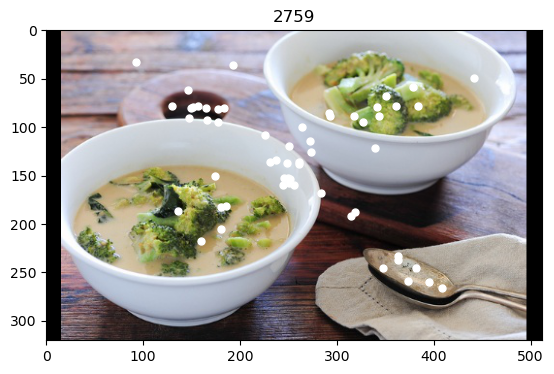

In [36]:
TA_fix.plot(example_img)

This displays all fixations on this image, regardless of which subject was viewing the image at the time. Let's find out which subject IDs are in out dataset and plot only fixations by one of them. The original dataset is available under the `.data` attribute as a DataFrame and supports all DataFrame operations. 

Moreover, Fixations objects support a `select()` operation which takes a dictionary as argument, with each dictionary key specifying one column from the original data file and each value specifying a list of values to select from this column. 

__Note: `select_fix()` does not automatically add the corresponding image id variable to its filter variables, so be sure to include it - otherwise fixations for multiple images are returned!__ If you are only interested in the plot, you can also add `select={'some_column': ['some', 'values']}` to the arguments of `plot()` without explicitly selecting fixations into a new dataset - this will return only fixations matching the selected image.

[ 12  37  45  50  51  57  92  96 103 111 116 118 122 146 149 158 170 173
 174 192 194 206 211 214 237 238 258 260 269 273 282 290 326   5   8  10
  13  31  35  52  83 113 124 126 143 144 165 167 171 178 180 181 224 250
 265 268 280 283 294 302 303 304 309 310  17  21  32  33  38  77  81  99
 101 121 131 139 152 159 162 169 184 202 215 226 228 241 254 277 289 319
 321  58  76  78  79  82  87  90 107 123 134 142 148 163 166 176 188 210
 218 257 262 267 271 307 320 323  23  30  36  65  73  85 125 132 135 147
 164 204 230 231 256 264 274 285 296 314 318  15  22  39  40  41  95 129
 136 153 198 200 203 208 212 217 234 272 305 315 329 330 332  59  63  74
  94  98 112 179 191 205 207 222 223 233 311 312 324 325  56  88 102 119
 128 138 154 155 201 236 246 278 291  11  43  46 109 177 185 186 220 242
 247 248 253 279 295 300   6  48  66  68  97 114 130 168 219 229 240 298
 299 301]


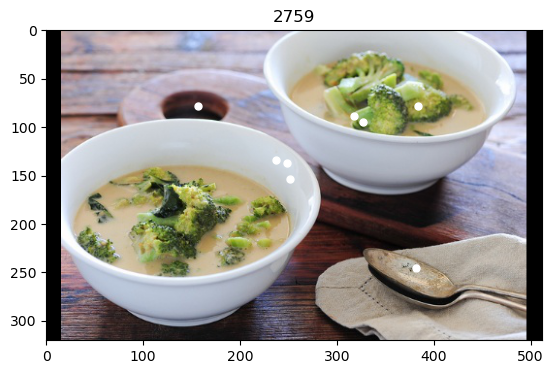

In [37]:
# Find all unique subject IDs in the dataset
print(TA_fix.data['TRIAL_INDEX'].unique())

# ...and create a subset of the fixation data for subject #192
subj_fix = TA_fix.select_fix(select={'TRIAL_INDEX': 192, 'image_id': example_img})

# Now plot only the fixations of subject #192
subj_fix.plot(example_img)

**Note**: if necessary, a Fixations object can also return an array of fixated/non-fixated pixels, either binary using e.g. subj_fix.location_map(), or containing the count of fixations for each pixel using .count_map().

## Using a RegionSet to evaluate fixated locations

After fixation data has been loaded and selected in this way, the resulting fixations can now be evaluated on a previously created RegionSet parcellation, returning the fixated and non-fixated regions (for the example grid: fixated and non-fixated grid cells):

In [38]:
# Determine fixated and non-fixated grid cells
fix_on_image = TA_grid.fixated(subj_fix)
print(fix_on_image)

# Number of returned values - this should match number of grid cells
print(len(fix_on_image))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

The result of this operation yields a binary value for each region in our previously created GridRegionSet: the respective cell has been fixated (1) or not (0). To visualize this result on the grid, we can simply plot the GridRegionSet as we did above, but this time pass the resulting fixations to the plotting function using the _values=_ argument:

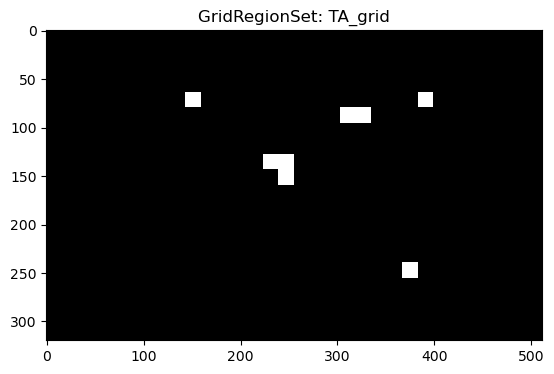

In [39]:
TA_grid.plot(values=fix_on_image)

When GridFix is used to create a predictor file for GLMM analysis, it is this vector of fixated and non-fixated regions that will be calculated alongside the other predictors and used as the **dependent variable** in the GLMM.

In case that not the fixated/non-fixated status of a cell but rather the absolute number of fixations is of interest, this information can simply be calculated and plotted by adding `var='count'` when calculating the fixated regions:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

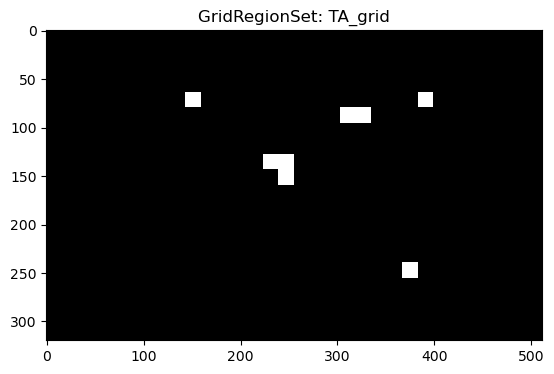

In [40]:
# Calculate number of fixations per cell...
count_fix = TA_grid.fixated(subj_fix, var='count')

# ...and visualize, specifying a colormap for easier visualization
TA_grid.plot(values=count_fix, cmap='hot')
print(count_fix)

Currently, the variables that can be passed to the ```fixated()``` function include:
- *fixated*: Return whether a cell was fixated (1) or not fixated (0). This is the default when called without ```var```
- *count*: Return the number of fixations received by each cell
- *fixid*: Return the numerical ID of the *first* fixation on each cell, or nan if not fixated

## Concluding Remarks

This concludes the first part of our GridFix tutorial. Since Jupyter notebooks are interactive when opened on your local machine, feel free to play around with the code in the above tutorial, for example by selecting a different image from the ImageSet or using a grid of different dimensions, then selecting "Cell > Run All" to recreate all results using new data.

## References

[1] Nuthmann, A., & Einhäuser, W. (2015). A new approach to modeling the influence of image features on fixation selection in scenes. Annals of the New York Academy of Sciences, 1339(1), 82-96. http://dx.doi.org/10.1111/nyas.12705

